<a href="https://colab.research.google.com/github/harshith7823/CS760-Project/blob/reetu/part-2/Death%20prediction/Model%20generated%20death%20column/part2_model_based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from numpy import mean
from numpy import std
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, ElasticNetCV,RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

In [ ]:
oppScrData = pd.read_excel(r'sample_data/OppScrData.xlsx')

In [ ]:
def preprocess_clinical_data(oppScrData, mean=True):
    clinical_data = oppScrData.filter(['Record ID','BMI', 'Clinical F/U interval  [d from CT]', 'Sex', 'Tobacco', 'Met Sx', 'FRAX 10y Fx Prob (Orange-w/ DXA)',
                                'FRAX 10y Hip Fx Prob (Orange-w/ DXA)','FRS 10-year risk (%)','Age at CT' ], axis=1)
    # Replace all _,X,blanks with nan
    clinical_data = clinical_data.replace(r'_', np.nan, regex=True)
    clinical_data = clinical_data.replace(r'X', np.nan, regex=True)
    clinical_data = clinical_data.replace(r'^\s*$', np.nan, regex=True)

    # Fill na in bmi column with mean
    clinical_data['BMI'].fillna(value=clinical_data['BMI'].mean(skipna=True), inplace=True)
    
    clinical_data['Sex'] = np.where(clinical_data['Sex']=='Male',1,-1)
    clinical_data['Met Sx'] = np.where(clinical_data['Met Sx']=='Y',1,-1) 

    # Treat no data in tobacco as no tobacco usage 
    clinical_data['Tobacco'] = np.where(clinical_data['Tobacco']=='Yes',1,-1) 
  
    clinical_data['FRS 10-year risk (%)'] = clinical_data['FRS 10-year risk (%)'].replace("<1", 0.01, regex=True)
    clinical_data['FRS 10-year risk (%)'] = clinical_data['FRS 10-year risk (%)'].replace(">30", 0.30, regex=True)
    clinical_data['FRS 10-year risk (%)'] =  clinical_data['FRS 10-year risk (%)'] * 100
   
    cols_to_be_filled = ['FRAX 10y Fx Prob (Orange-w/ DXA)','FRAX 10y Hip Fx Prob (Orange-w/ DXA)','FRS 10-year risk (%)']
    for c in cols_to_be_filled:
      if mean:  
        clinical_data[c].fillna(value=clinical_data[c].mean(skipna=True), inplace=True)
      else :
        clinical_data[c].fillna(value=clinical_data[c].median(skipna=True), inplace=True)

    return [clinical_data, np.array(clinical_data, dtype=np.float32)]

In [ ]:
def clean_ct_data(oppScrData):
    # Delete rows with empty values
    ct_data= oppScrData[["Record ID", "L1_HU_BMD", "TAT Area (cm2)", 'Total Body                Area EA (cm2)',
       'VAT Area (cm2)', 'SAT Area (cm2)', 'VAT/SAT     Ratio', 'Muscle HU',
       ' Muscle Area (cm2)', 'L3 SMI (cm2/m2)', 'AoCa        Agatston',
       'Liver HU    (Median)', 'Age at CT']]
    ct_data['Liver HU    (Median)'].replace(' ', np.nan, inplace=True)
    ct_data.dropna(axis = 0, how ='any', thresh = None, subset = None, inplace=True)
    ct_data[ 'DEATH [d from CT]'] = oppScrData[ 'DEATH [d from CT]']
    return [ct_data, np.array(ct_data, dtype=np.float32)]

In [ ]:
sc = StandardScaler()
ct_data, ct_data_np = clean_ct_data(oppScrData=oppScrData)
clinical_data, clinical_data_np = preprocess_clinical_data(oppScrData)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [ ]:
combined_data = clinical_data.merge(ct_data, on='Record ID', how='inner' )
combined_data.drop(columns = ['Record ID'], inplace=True)
print(combined_data.columns)
print(combined_data.shape)

Index(['BMI', 'Clinical F/U interval  [d from CT]', 'Sex', 'Tobacco', 'Met Sx',
       'FRAX 10y Fx Prob (Orange-w/ DXA)',
       'FRAX 10y Hip Fx Prob (Orange-w/ DXA)', 'FRS 10-year risk (%)',
       'Age at CT_x', 'L1_HU_BMD', 'TAT Area (cm2)',
       'Total Body                Area EA (cm2)', 'VAT Area (cm2)',
       'SAT Area (cm2)', 'VAT/SAT     Ratio', 'Muscle HU',
       ' Muscle Area (cm2)', 'L3 SMI (cm2/m2)', 'AoCa        Agatston',
       'Liver HU    (Median)', 'Age at CT_y', 'DEATH [d from CT]'],
      dtype='object')
(8878, 22)


In [ ]:
non_null_death_rows = combined_data[~combined_data['DEATH [d from CT]'].isnull()]
print(non_null_death_rows.shape)
print(non_null_death_rows.columns)

(493, 22)
Index(['BMI', 'Clinical F/U interval  [d from CT]', 'Sex', 'Tobacco', 'Met Sx',
       'FRAX 10y Fx Prob (Orange-w/ DXA)',
       'FRAX 10y Hip Fx Prob (Orange-w/ DXA)', 'FRS 10-year risk (%)',
       'Age at CT_x', 'L1_HU_BMD', 'TAT Area (cm2)',
       'Total Body                Area EA (cm2)', 'VAT Area (cm2)',
       'SAT Area (cm2)', 'VAT/SAT     Ratio', 'Muscle HU',
       ' Muscle Area (cm2)', 'L3 SMI (cm2/m2)', 'AoCa        Agatston',
       'Liver HU    (Median)', 'Age at CT_y', 'DEATH [d from CT]'],
      dtype='object')


In [ ]:
# Convert to years
non_null_death_rows['DEATH [d from CT]'] /= 365

X = non_null_death_rows.iloc[:, 0:21]
y = non_null_death_rows.iloc[:, 21]
X = pd.DataFrame(sc.fit_transform(X), columns = X.columns)
print(X.shape)

null_death_rows = combined_data[combined_data['DEATH [d from CT]'].isnull()]
X2 = null_death_rows.iloc[:, 0:21]
X2 = pd.DataFrame(sc.fit_transform(X2), columns = X2.columns)

print(X2.shape)

(493, 21)
(8385, 21)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
def testWithModel(model, X_train, X_test, y_train, y_test):
  clf = model
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  print(f'MAE = {mean_absolute_error(y_test, y_pred)}') 
  print(f'MAPE = {mean_absolute_percentage_error(y_test, y_pred)}')
  print(f'RMSE = {mean_squared_error(y_test, y_pred)**0.5}')

  plot_results(y_test, y_pred)

  return y_pred

In [ ]:
def plot_results(y_test, y_pred):
  plt.figure()
  y_test_sub, y_pred_sub = y_test, y_pred
  if len(y_test)>200:
    y_test_sub, y_pred_sub = y_test[::15], y_pred[::15]
    
  x = [i+1 for i in range(len(y_test_sub))]
  plt.plot((x,x),([i for i in y_pred_sub], [j for j in y_test_sub]),c='green',markevery=5,)
  plt.scatter(x, y_pred_sub, label="predicted_y")
  plt.scatter(x, y_test_sub, label="actual_y")
  plt.xlabel("X")
  plt.ylabel("Y")
  plt.legend()
  plt.show()

In [ ]:
print(X_train.shape)
print(X_test.shape)

(394, 21)
(99, 21)


MAE = 0.3942952701660138
MAPE = 0.3824933713166473
RMSE = 0.881574710256912


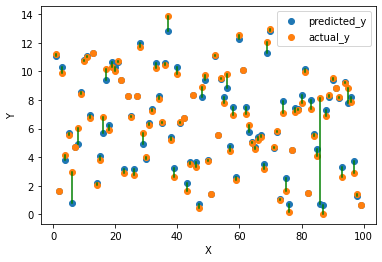

In [ ]:
RFparams2={'n_estimators':[80],
          'min_samples_split':[20],
          'min_samples_leaf': [4],
           'max_features': [21],
           'max_depth': [20],
           'bootstrap': [True]}

#  {'bootstrap': True, 'max_depth': 20, 'max_features': 21, 'min_samples_leaf': 4, 'min_samples_split': 20, 'n_estimators': 80}

rf = RandomForestRegressor(random_state = 21)
clf_random_forest = GridSearchCV(rf, RFparams2, refit=True)
rf_pred = testWithModel(clf_random_forest ,X_train, X_test, y_train, y_test )

MAE = 0.5867287367814195
MAPE = 0.7200536601761603
RMSE = 0.9234693295618769


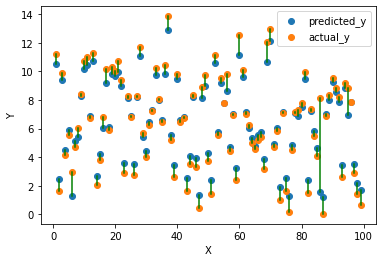

In [ ]:
lasso_pred = testWithModel(Lasso(alpha=0.5), X_train, X_test, y_train, y_test)

MAE = 0.335849276508067
MAPE = 0.28821906314800805
RMSE = 0.8444237153301599


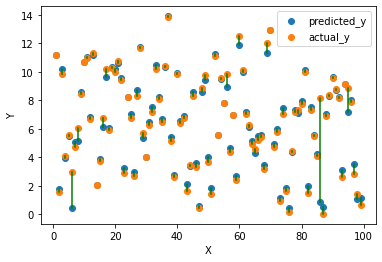

In [ ]:
ridge_pred = testWithModel(RidgeCV(),X_train, X_test, y_train, y_test)

MAE = 1.7164221406683864
MAPE = 1.9289060494961476
RMSE = 2.1868295249854506


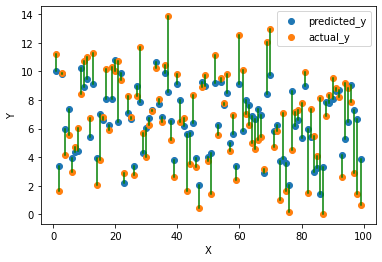

In [ ]:
knn_pred = testWithModel(KNeighborsRegressor(n_neighbors = 5, weights = 'distance'),X_train, X_test, y_train, y_test)

MAE = 0.5057423550574235
MAPE = 0.34802301921197437
RMSE = 1.1823503826092487


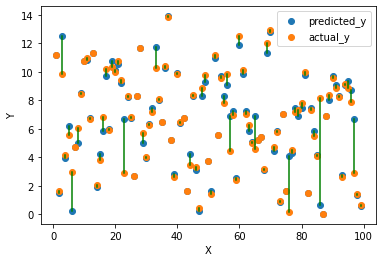

In [ ]:
dtree_pred = testWithModel(DecisionTreeRegressor(criterion="absolute_error"),X_train, X_test, y_train, y_test)

MAE = 0.3357915817776883
MAPE = 0.33066385692917183
RMSE = 0.8350667869176001


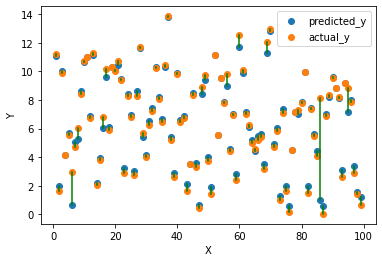

In [ ]:
elastic_pred = testWithModel(ElasticNetCV(random_state=0), X_train, X_test, y_train, y_test)

MAE = 1.0200425050216366
MAPE = 0.47129811467065724
RMSE = 1.4163654691945058


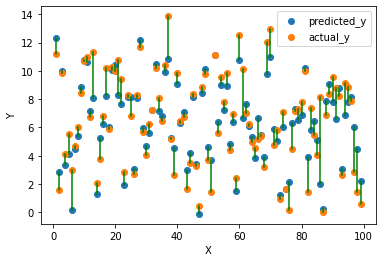

In [ ]:
svr_pred = testWithModel(SVR(C=300, epsilon=0.8),X_train, X_test, y_train, y_test)

Fill death column using random forest

In [ ]:
null_death_rows['DEATH [d from CT]'] = clf_random_forest.predict(X2)
df = pd.concat([non_null_death_rows,null_death_rows])

y = df.iloc[:,21]
X = df.iloc[:, 0:21]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
print(X.shape)

(8878, 21)


In [ ]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2)

MAE = 0.21973955474238924
MAPE = 0.06163227598586087
RMSE = 0.47529191675538296


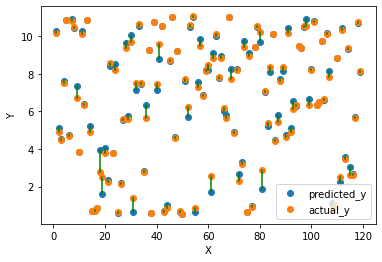

In [ ]:
knn = KNeighborsRegressor(n_neighbors=9)
param_grid2 = dict(weights = ["uniform", "distance"])
knn_pred = testWithModel(GridSearchCV(knn, param_grid2),X_train, X_test, y_train, y_test)

MAE = 0.5280503842097949
MAPE = 0.16812817729276852
RMSE = 0.6359332885047823


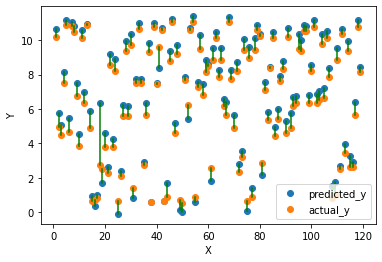

In [ ]:
svr_pred = testWithModel(SVR(C=300, epsilon=0.8),X_train, X_test, y_train, y_test)

MAE = 0.341234782417876
MAPE = 0.17053753177748432
RMSE = 0.5319051957607591


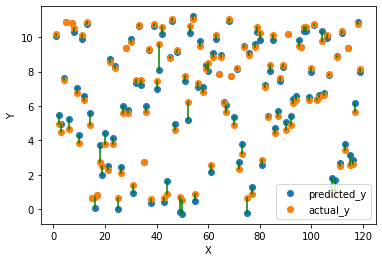

In [ ]:
lasso_pred = testWithModel(Lasso(alpha=0.1), X_train, X_test, y_train, y_test)

MAE = 0.3481039988382167
MAPE = 0.17216307474154932
RMSE = 0.5449005378846906


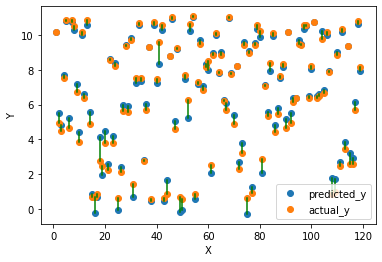

In [ ]:
elastic_net_pred = testWithModel(ElasticNetCV(random_state=0), X_train, X_test, y_train, y_test)

MAE = 0.20782645625138832
MAPE = 0.06343836506637086
RMSE = 0.6288053969398144


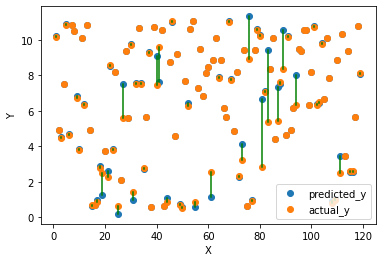

In [ ]:
dtree_pred = testWithModel(DecisionTreeRegressor(criterion="absolute_error"),X_train, X_test, y_train, y_test)